# 딥러닝 RNN 기반의 검색 빈도수를 이용한 주가예측
 - FCN 모델은 현재 시점만 보고 결정: 야 너 지금 가격 35500원인데 살래말래?
 - 반면 RNN은 어제, 그제, 그그제 가격이 42300, 41000, 37000원 이었거든? 살래말래?

# 0. Install packages

In [1]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 2.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [3]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [4]:
df = fdr.DataReader('036570','2022-01-02', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [5]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-01-03,645000,689000,644000,667000,237394,0.037325
2022-01-04,662000,669000,654000,657000,111602,-0.014993
2022-01-05,652000,654000,622000,625000,196204,-0.048706
2022-01-06,617000,622000,599000,601000,206173,-0.038400
2022-01-07,606000,620000,603000,606000,125308,0.008319
...,...,...,...,...,...,...
2022-04-06,475000,483500,469000,474000,96750,-0.012500
2022-04-07,469000,471500,462000,462000,103079,-0.025316
2022-04-08,462500,466500,453500,458000,87055,-0.008658


In [6]:
df = df.fillna(0)

(array([738156., 738170., 738187., 738201., 738215., 738229., 738246.,
        738260.]), <a list of 8 Text major ticklabel objects>)

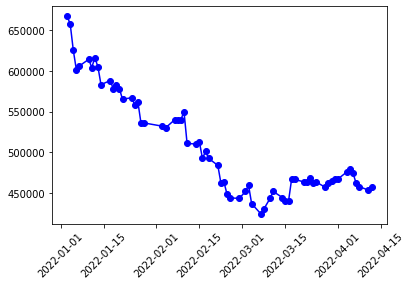

In [7]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [8]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2022-01-02\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"KAI_0\",\"keywords\":[\"기아\"]}, {\"groupName\":\"KAI_1\",\"keywords\":[\"중고차\"]}, {\"groupName\":\"KAI_2\",\"keywords\":[\"리콜\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [9]:
search_count_json = json.loads(search_count)

## 1-3. 데이터 전처리 및 Merge하기

In [10]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [11]:
df_all = df

In [12]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

-0.3216858919029978

In [13]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

-0.3216858919029978

In [14]:
#df_all[df_all["Count"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

In [15]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
Key_Count2    False
dtype: bool

In [16]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0,Key_Count1,Key_Count2
0,2022-01-03,645000,689000,644000,667000,237394,0.037325,53.52948,69.85006,0.83924
1,2022-01-04,662000,669000,654000,657000,111602,-0.014993,54.69714,66.97737,0.75963
2,2022-01-05,652000,654000,622000,625000,196204,-0.048706,68.64924,67.76023,0.80939
3,2022-01-06,617000,622000,599000,601000,206173,-0.038400,58.62469,65.31214,0.89232
4,2022-01-07,606000,620000,603000,606000,125308,0.008319,61.21210,64.60558,0.78617
...,...,...,...,...,...,...,...,...,...,...
62,2022-04-06,475000,483500,469000,474000,96750,-0.012500,100.00000,63.02660,0.98852
63,2022-04-07,469000,471500,462000,462000,103079,-0.025316,67.23280,61.49074,1.73489
64,2022-04-08,462500,466500,453500,458000,87055,-0.008658,54.61421,58.79055,1.10794
65,2022-04-11,450500,459000,449000,453500,59322,-0.009825,73.23027,63.77628,0.95203


## 1-4. Feature Selection

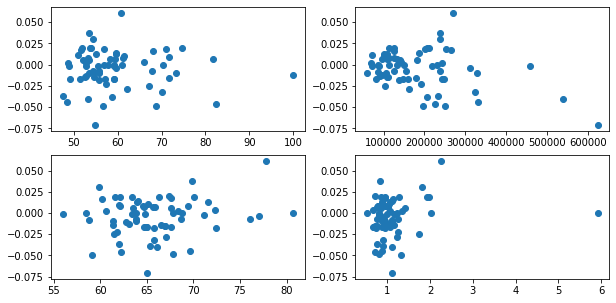

In [17]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Volume"], df_all["Change"])
ax3.scatter(df_all["Key_Count1"], df_all["Change"])
ax4.scatter(df_all["Key_Count2"], df_all["Change"])

# 2. Define Model

In [18]:
#https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
#rnn 예제를 보고 일단 한번 돌려봅시다
rnn = torch.nn.RNN(2, 100, 1, batch_first=True)
input = torch.randn(1, 5, 2)
h0 = torch.randn(1, 1, 100)
output, hn = rnn(input, h0)

In [19]:
input_size = 3
batch_size = 1
sequence_size = 5
hidden_size = 100
layer_size = 1
batch_first = True
rnn = torch.nn.RNN(input_size, hidden_size, layer_size, batch_first=batch_first)
input = torch.randn(batch_size, sequence_size, input_size)
h0 = torch.randn(1*layer_size, batch_size, hidden_size)
output, hn = rnn(input, h0) #(모든 sequence에 대한 hidden 값, 맨마지막 seq에 대한 hidden 값)

In [20]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layer=1, batch_first=True):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layer, batch_first=batch_first)
        self.relu = torch.nn.ReLU()
        self.linear_classifier = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):

        all_hidden, last_hidden = self.rnn(x.unsqueeze(0))
        #x = self.relu(last_hidden)
        x = self.linear_classifier(all_hidden[:, -1])
        return x

# 3. Define the loss function and the optimizer

In [21]:
input_size = 3
hidden_size = 10
sequence_size = 5
output_size = 1
layer_size = 1

learning_rate = 0.001
model = RNNModel(input_size, hidden_size, output_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [22]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0', 'Scaled_Key_Count1', 'Scaled_Key_Count2']] = scaler.fit_transform(df[['Key_Count0', 'Key_Count1', 'Key_Count2']])

In [24]:
df_all = df

In [25]:
'''
s_idx, e_idx, date_interval, num_days = 0, len(df_all), 1, 4
for idx in range(s_idx, e_idx-s_idx, date_interval):
  print(df_all.loc[idx:idx+num_days])
'''

'\ns_idx, e_idx, date_interval, num_days = 0, len(df_all), 1, 4\nfor idx in range(s_idx, e_idx-s_idx, date_interval):\n  print(df_all.loc[idx:idx+num_days])\n'

In [26]:
seq_x = []
seq_y = []
feature_list = ['Scaled_Key_Count0', 'Scaled_Key_Count1', 'Scaled_Key_Count2']
s_idx, e_idx, date_interval, num_days = 0, len(df_all), 1, 4
for idx in range(s_idx, e_idx-s_idx, date_interval):
  x = df_all.loc[idx:idx+num_days][feature_list].to_numpy().tolist()
  y = df_all.loc[idx:idx+num_days]["Change"].sum().tolist()
  seq_x.append(x) if len(x) == 5 else None
  seq_y.append(y) if len(x) == 5 else None

train_x, test_x, train_y, test_y = train_test_split(seq_x, seq_y, test_size=0.2)

In [27]:
best_model = None
num_epoch = 500
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


<BarContainer object of 500 artists>

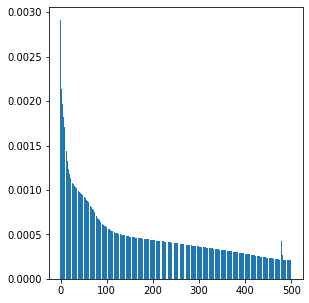

In [28]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)

ax1.bar(range(num_epoch), loss_epoch)

# 7. Evaluation

In [29]:
x_predicted = []
for idx in range(len(train_x)):
  predicted = model(torch.tensor(train_x[idx]).float())
  x_predicted.append(predicted.detach())
x_pred_np = np.array(x_predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


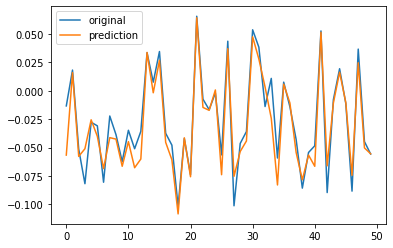

In [30]:
plt.plot(train_y[:100])
plt.plot(x_pred_np[:100])
plt.legend(['original', 'prediction'])
plt.show()

In [31]:
x_predicted = []
for idx in range(len(test_x)):
  predicted = model(torch.tensor(test_x[idx]).float())
  x_predicted.append(predicted.detach())
x_pred_np = np.array(x_predicted)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


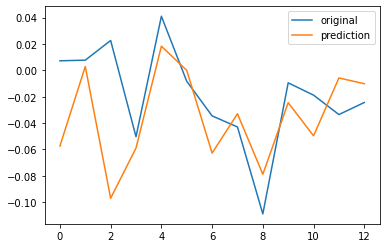

In [32]:
plt.plot(test_y[:100])
plt.plot(x_pred_np[:100])
plt.legend(['original', 'prediction'])
plt.show()

# 6. Prediction

In [33]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [38]:
raw_input = [[74.4,90.1,1.3],[74.6,84.4,1.2],[52.9,80.4,0.7],[51.9,89.3,1.6],[77.7,100,1.4]]
scaled_input = []
for a_day in raw_input:
  key_count = np.array(a_day)
  scaled = scaler.transform(key_count.reshape(1,-1)).tolist()[0]
  scaled_input.append(scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na

In [39]:
scaled_input

[[0.5129149831156548, 1.3788898052175838, 0.1433225178696319],
 [0.5167203348100633, 1.148798458953117, 0.12477112215537535],
 [0.10383967596669241, 0.987330847539456, 0.03201414358409256],
 [0.08481291749464781, 1.3465962829348515, 0.1989767050124016],
 [0.5757032860734022, 1.7785221434663954, 0.16187391358388847]]

In [40]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [41]:
print("검색량이"+str(raw_input)+"일때 주가는", str(predicted.item()*100) )

검색량이[[74.4, 90.1, 1.3], [74.6, 84.4, 1.2], [52.9, 80.4, 0.7], [51.9, 89.3, 1.6], [77.7, 100, 1.4]]일때 주가는 -15.871116518974304
